STAT 453: Intro to Deep Learning and Generative Models (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

# ADALINE with Stochastic Gradient Descent (Minibatch)

![](figures/adaline-concept.png)

In this notebook, we are implementing ADALINE "by hand" without using PyTorch's autograd capabilities. In Lecture 06, we will use "automatic differentiation" (also known as "autodiff"; or autograd in PyTorch) to implement Adaline more compactly. (The reason why we don't use autodiff here is that it is useful to understand what's going on under the hood.) 

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Gradient descent theory
[Slides](https://sebastianraschka.com/pdf/lecture-notes/stat453ss21/L05_gradient-descent_slides.pdf) and [lecture video](https://www.youtube.com/watch?v=L4xzybIa-bo&t=520s)
<div>
<img src="Screenshot_20230101_013641.png" width="700"/>
</div>
<div>
<img src="Screenshot_20230101_020211.png" width="700"/>
</div>

Recall $$\nabla_w L=\left(\frac{\partial L}{\partial w_1},\dots \right)$$
and $$\sigma(\mathbf w^Tx^{[i]})=\hat{y}^{[i]}$$
This should help justify part 2.A.(b) in the first slide above

<div>
<img src="Screenshot_20230101_023127.png" width="700"/>
</div>

See above for normalization of inputs

<br>
<br>

## Differences between Perceptron and Adaline
Raschka in the second slide below implies/states that the Adaline model is a modification of the Perceptron classification model. The Adaline model in this notebook is also used for classification. 
1. The Perceptron will not converge if the training set is not "linearly separable" while the Adaline will converge (with some error). Image is taken from the last code block of this notebook. 

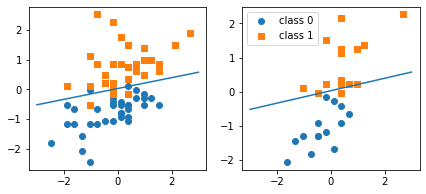

2. The Perceptron and Adaline have different learning rules (i.e. different methods of adjusting the weights $w_i$ which will form the linear separatrix $w_1 x_1+ w_2x_2 + \dots = b$). The learning rule for the Perceptron is shown in the left column of the first slide below and is discussed in this [video](https://www.youtube.com/watch?v=C8Uns9HEVXI&list=PLTKMiZHVd_2KJtIXOW0zFhFfBaJJilH51). Note that the function $\sigma$ in 2.A.(a) includes the threshold function as $\hat{y}[i]\in\{0,1\}.$ This agrees with the Perceptron flowchart in the second slide. The learning rule for Adaline is shown in the right column of the first slide below. Note the use of gradient descent in Adaline (not used in Perceptron). Also note that the function $\sigma$ in 2.A.(a) in the right column of the first slide does NOT include the threshold function as $\hat{y}[i]$ is a continuous (not discrete) variable.
3. The Adaline classifier is closely related to the Ordinary Least Squares (OLS) Linear Regression algorithm; see [Raschka](http://rasbt.github.io/mlxtend/user_guide/classifier/Adaline/).


<div>
<img src="Screenshot_20230101_013641.png" width="700"/>
</div>
<div>
<img src="Screenshot_20230121_113234.png" width="700"/>
</div>

## Load & Prepare a Toy Dataset
This is a simplification of the canonical Iris dataset. The simplification is a restriction to only two classes which have been renamed to 0 and 1. Also only two features $x_2, x3$ are used; see code 

```X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)```

below. This is probably done for simplicity as the plot of four features (and classification label) would require colored points in four dimensional space. By restricting to two features, we only need to plot colored points in the Cartesian plane (as shown below in the training and test set plots).
It would seem that the regression done here is multivariate (two regressors $x2, x3$ (ind) and one regressand $y$ (dep)) which can be visualized using a plane in three space similar to:

<div>
<img src="Screenshot_20230122_014915.png" width="700"/>
</div>


In [8]:
df = pd.read_csv('./datasets/iris.data', index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)
df.tail()

,x1,x2,x3,x4,y
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1
149,5.9,3.0,5.1,1.8,1


In [10]:
# Assign features and target

X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0)*0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

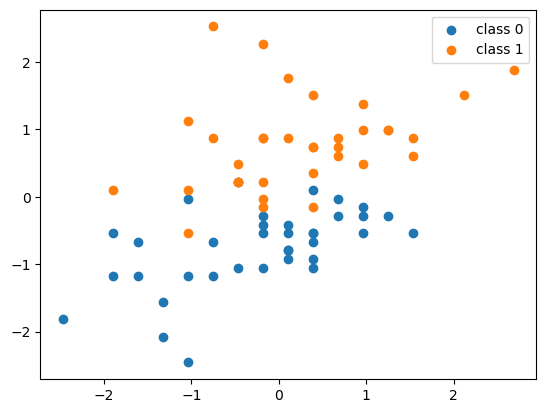

In [11]:
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='class 0')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='class 1')
plt.legend()
plt.show()

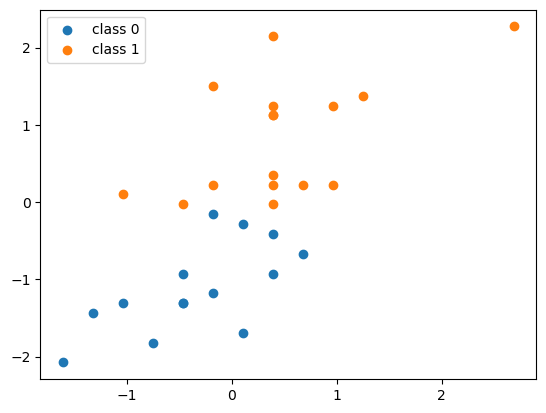

In [12]:
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='class 0')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='class 1')
plt.legend()
plt.show()

<br>
<br>

## Implement ADALINE Model

In [13]:
class Adaline1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):  
        
        grad_loss_yhat = 2*(yhat - y)
        
        grad_yhat_weights = x
        grad_yhat_bias = 1.
        
        # Chain rule: inner times outer
        grad_loss_weights = torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

<br>
<br>

## Define Training and Evaluation Functions
In the code below, training is done in *minibatches*; see time 24:38 of this [video](https://www.youtube.com/watch?v=GGcaqzhKzLc&t=599s)

In [14]:
####################################################
##### Training and evaluation wrappers
###################################################

def loss(yhat, y):
    return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        #### Shuffle epoch
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)   # create a list of minibatches
        
        for minibatch_idx in minibatches:

            #### Compute outputs ####
            yhat = model.forward(x[minibatch_idx])

            #### Compute gradients ####
            negative_grad_w, negative_grad_b = \
                model.backward(x[minibatch_idx], yhat, y[minibatch_idx])

            #### Update weights ####
            model.weights += learning_rate * negative_grad_w
            model.bias += learning_rate * negative_grad_b
            
            #### Logging ####
            minibatch_loss = loss(yhat, y[minibatch_idx])
            print('    Minibatch MSE: %.3f' % minibatch_loss)

        #### Logging ####
        yhat = model.forward(x)
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

<br>
<br>

## Train Model

In [15]:
model = Adaline1(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=20,
             learning_rate=0.1,
             seed=123,
             minibatch_size=10)

    Minibatch MSE: 0.500
    Minibatch MSE: 0.341
    Minibatch MSE: 0.220
    Minibatch MSE: 0.245
    Minibatch MSE: 0.157
    Minibatch MSE: 0.133
    Minibatch MSE: 0.144
Epoch: 001 | MSE: 0.12142
    Minibatch MSE: 0.107
    Minibatch MSE: 0.147
    Minibatch MSE: 0.064
    Minibatch MSE: 0.079
    Minibatch MSE: 0.185
    Minibatch MSE: 0.063
    Minibatch MSE: 0.135
Epoch: 002 | MSE: 0.09932
    Minibatch MSE: 0.093
    Minibatch MSE: 0.064
    Minibatch MSE: 0.128
    Minibatch MSE: 0.099
    Minibatch MSE: 0.079
    Minibatch MSE: 0.157
    Minibatch MSE: 0.080
Epoch: 003 | MSE: 0.09693
    Minibatch MSE: 0.131
    Minibatch MSE: 0.146
    Minibatch MSE: 0.050
    Minibatch MSE: 0.095
    Minibatch MSE: 0.106
    Minibatch MSE: 0.072
    Minibatch MSE: 0.102
Epoch: 004 | MSE: 0.09658
    Minibatch MSE: 0.107
    Minibatch MSE: 0.204
    Minibatch MSE: 0.149
    Minibatch MSE: 0.054
    Minibatch MSE: 0.060
    Minibatch MSE: 0.056
    Minibatch MSE: 0.069
Epoch: 005 | MSE: 0.0

<br>
<br>

## Evaluate ADALINE Model

### Plot Loss (MSE)

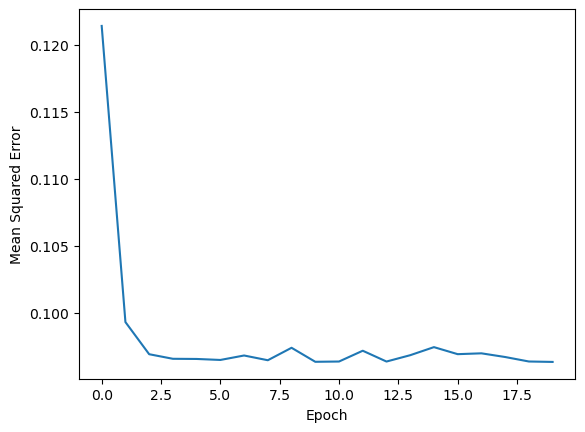

In [17]:
plt.plot(range(len(cost)), cost)  # a list of costs is created in the Training and Evaluation block above
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

<br>
<br>

### Compare with analytical solution

In [19]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[-0.0763],
        [ 0.4181]])
Bias tensor([0.4888])


In [20]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train.float())
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[-0.0703],
        [ 0.4219]])
Analytical bias tensor([0.4857])


<br>
<br>

## Evaluate on Evaluation Metric (Prediction Accuracy)
<div>
<img src="Screenshot_20230121_113234.png" width="700"/>
</div>


In the code below, note that we are applying the threshold function after convergence (compare to Adaline flowchart above). See time 28:25 of this [video](https://www.youtube.com/watch?v=GGcaqzhKzLc&t=599s) for description of the following code block

In [24]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, 
                 ones, 
                 zeros).int() == y_train).float())

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5, 
                 ones, 
                 zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 90.00
Test Accuracy: 96.67


<br>
<br>

## Decision Boundary

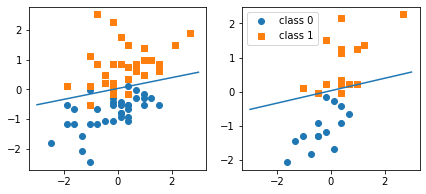

In [15]:
##########################
### 2D Decision Boundary
##########################

w, b = model.weights, model.bias - 0.5

x_min = -3
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 3
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

Need to reconcile above images with interpretation of multivariate (two regressors $x2, x3$ (ind) and one regressand $y$ (dep)) regression which can be visualized using a plane in three space

<div>
<img src="Screenshot_20230122_014915.png" width="700"/>
</div>